# Predicting gender from names

## Table of Contents

##### I. <a href=#I>Preliminary steps</a>
##### II. <a href=#II>Prepare the data</a>
##### III. <a href=#III>Feed-forward neural network model</a>
##### IV. <a href=#IV>Long short-term memory model</a>
##### V. <a href=#V>Naive discriminative learning model</a>

## I. Preliminary steps <a ID="I"></a> 

### Import necessary libraries and set up the working directory

In [2]:
### Import necessary packages
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras import metrics
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings

### Set working directory
TOP = '/media/adnane/HDD drive/Adnane/PostDoc_ooominds/Programming/Deep_text_modelling_package_repo/'
#TOP = 'F:/Adnane/PostDoc_ooominds/Programming/Deep_text_modelling_package_repo/'
#TOP = '/media/Deep_text_modelling_package_repo/'
WD = TOP + 'package'
os.chdir(WD)

### Import local packages
import deep_text_modelling.preprocessing as pr
import deep_text_modelling.modelling as md
import deep_text_modelling.evaluation as ev

# Display option for dataframes and matplotlib
pd.set_option('display.max_colwidth', 100) # Max width of columns when dispalying datasets
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
warnings.filterwarnings('ignore') # Hide warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [134]:
import imp
imp.reload(pr)
imp.reload(md)
imp.reload(ev)

<module 'deep_text_modelling.evaluation' from '/media/adnane/HDD drive/Adnane/PostDoc_ooominds/Programming/Deep_text_modelling_package_repo/package/deep_text_modelling/evaluation.py'>

### Define file paths

In [3]:
NAMES_FULL_CSV = TOP + "illustrative_examples/names/Data/Names_full.csv"
NAMES_TRAIN_CSV = TOP + "illustrative_examples/names/Data/Names_train.csv"
NAMES_VALID_CSV = TOP + "illustrative_examples/names/Data/Names_valid.csv"
NAMES_TEST_CSV = TOP + "illustrative_examples/names/Data/Names_test.csv"
CUE_INDEX = TOP + "illustrative_examples/names/Data/Cue_index.csv"
OUTCOME_INDEX = TOP + "illustrative_examples/names/Data/Outcome_index.csv"

### Parameters to use

In [4]:
N_outcomes = 2  # number of (most frequent) outcomes to keep (here all possible outcomes)
N_cues = 26  # number of (most frequent) cues to keep (here all alphabet letters)
prop_valid = 1/10 # proportion of validation data
prop_test = 1/10 # proportion of test data

## II. Prepare the data <a name="II"></a> 

### Load the data

In [5]:
names_full = pd.read_csv(NAMES_FULL_CSV)
print(f'Number of examples: {len(names_full)}')
names_full.head(5)

Number of examples: 6782


,first_name,gender
0,John,m
1,William,m
2,James,m
3,Charles,m
4,George,m


### Prepare the cues and outcomes

In [8]:
# Create the unigraph cues
names_full['cues'] = names_full['first_name'].apply(lambda s: pr.orthoCoding(s, gram_size = 1))

# Rename the column gender as 'outcomes'
names_full.rename(columns={"gender": "outcomes"}, inplace = True)
names_full = names_full[['cues', 'outcomes']]
names_full.head(5)

,cues,outcomes
0,j_o_h_n,m
1,w_i_l_l_i_a_m,m
2,j_a_m_e_s,m
3,c_h_a_r_l_e_s,m
4,g_e_o_r_g_e,m


### Create index systems for the cues and outcomes

In [9]:
# Create the files containing the index systems
pr.create_index_systems_from_df(data = names_full, 
                                cue_index_path = CUE_INDEX, 
                                outcome_index_path = OUTCOME_INDEX)

In [10]:
# Import the cue index system
cue_to_index = pr.import_index_system(CUE_INDEX, N_tokens = N_cues)
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{a: 1}
{e: 2}
{n: 3}
{i: 4}
{l: 5}


In [11]:
# Order dictionary alphabetically
cue_to_index = {k:(i+1) for i,k in enumerate(sorted(cue_to_index.keys()))}
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{a: 1}
{b: 2}
{c: 3}
{d: 4}
{e: 5}


In [12]:
# Import the outcome index system
outcome_to_index = pr.import_index_system(OUTCOME_INDEX)
outcome_to_index

{'m': 1, 'f': 2}

In [13]:
# Reverse the cue dictionary
index_to_cue = pr.reverse_dictionary(cue_to_index)
# Reverse the outcome dictionary
index_to_outcome = pr.reverse_dictionary(outcome_to_index)
index_to_outcome

{1: 'm', 2: 'f'}

### Split into training, validation and test sets

In [11]:
# Create train, valid and test set files
pr.df_train_valid_test_split(data = names_full, 
                             train_data_path = NAMES_TRAIN_CSV, 
                             valid_data_path = NAMES_VALID_CSV, 
                             test_data_path = NAMES_TEST_CSV, 
                             p_valid = prop_valid, 
                             p_test = prop_test)

- Number of rows in the original set is 6782
- Number of rows in the training set is 5426
- Number of rows in the validation set is 678
- Number of rows in the test set is 678


In [14]:
# Load the train, valid and test sets
names_train = pd.read_csv(NAMES_TRAIN_CSV, sep=',', na_filter = False)
names_valid = pd.read_csv(NAMES_VALID_CSV, sep=',', na_filter = False)
names_test = pd.read_csv(NAMES_VALID_CSV, sep=',', na_filter = False)

## III. Feed-forward neural network model <a ID="III"></a> 

### Tokenisation

In [15]:
# Extract an event
event4 = names_train.iloc[[4]]
event4

,cues,outcomes
4,s_t_e_r_l_i_n_g,m


In [16]:
# cues (if max_len not specified, all the cues in the sequences will be considered)
cues4 = names_train.loc[names_train.index[4], 'cues']
cues4_onehot_FNN = md.seq_to_onehot_1darray(cues4, index_system = cue_to_index, N_tokens = N_cues, max_len = None)
cues4_onehot_FNN

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [17]:
# cues (if max_len specified, only 'max_len' first cues in a sequence will be considered)
cues4 = names_train.loc[names_train.index[4], 'cues']
cues4_onehot_FNN = md.seq_to_onehot_1darray(cues4, index_system = cue_to_index, N_tokens = N_cues, max_len = 4)
cues4_onehot_FNN

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [18]:
# outcomes
outcomes4 = names_train.loc[names_train.index[4], 'outcomes']
outcomes4_onehot_FNN = md.seq_to_onehot_1darray(outcomes4, index_system = outcome_to_index, N_tokens = N_outcomes)
outcomes4_onehot_FNN

array([1., 0.])

### Build a simple FNN model

Build a simple FNN with two hidden layers having 64 units 

In [19]:
### Hyperparameters to use
p = {'max_len': None,
     'epochs': 10, # number of iterations on the full set 
     'batch_size': 16, 
     'embedding_input': None,
     'hidden_layers': 2, # number of hidden layers 
     'hidden_neuron':64, # number of neurons in the input layer 
     'lr': 0.0001, # learning rate       
     'dropout': 0.2, 
     'optimizer': Adam, 
     'losses': binary_crossentropy, 
     'activation': relu, 
     'last_activation': 'sigmoid'}

# Model fitting
FNN_hist, FNN_model = md.train(model = 'FNN',
                               data_train = names_train, 
                               data_valid = names_valid, 
                               cue_index = cue_to_index, 
                               outcome_index = outcome_to_index, 
                               verbose = 2,
                               metrics = ['accuracy'],
                               params = p)

Epoch 1/10
 - 4s - loss: 0.6942 - accuracy: 0.5102 - val_loss: 0.6929 - val_accuracy: 0.5685
Epoch 2/10
 - 3s - loss: 0.6847 - accuracy: 0.5563 - val_loss: 0.6867 - val_accuracy: 0.6228
Epoch 3/10
 - 3s - loss: 0.6746 - accuracy: 0.5946 - val_loss: 0.6777 - val_accuracy: 0.6257
Epoch 4/10
 - 3s - loss: 0.6613 - accuracy: 0.6221 - val_loss: 0.6695 - val_accuracy: 0.6369
Epoch 5/10
 - 3s - loss: 0.6499 - accuracy: 0.6290 - val_loss: 0.6600 - val_accuracy: 0.6451
Epoch 6/10
 - 3s - loss: 0.6389 - accuracy: 0.6411 - val_loss: 0.6482 - val_accuracy: 0.6555
Epoch 7/10
 - 3s - loss: 0.6330 - accuracy: 0.6469 - val_loss: 0.6385 - val_accuracy: 0.6607
Epoch 8/10
 - 3s - loss: 0.6292 - accuracy: 0.6472 - val_loss: 0.6287 - val_accuracy: 0.6615
Epoch 9/10
 - 3s - loss: 0.6207 - accuracy: 0.6593 - val_loss: 0.6186 - val_accuracy: 0.6652
Epoch 10/10
 - 3s - loss: 0.6201 - accuracy: 0.6568 - val_loss: 0.6115 - val_accuracy: 0.6689


In [20]:
FNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 6,018
Trainable params: 6,018
Non-trainable params: 0
_________________________________________________________________


In [22]:
### Hyperparameters to use
p = {'max_len': None,
     'epochs': 10, # number of iterations on the full set 
     'batch_size': 16, 
     'embedding_input': None,
     'embedding_dim': 0,
     'hidden_layers': 2, # number of hidden layers 
     'hidden_neuron':64, # number of neurons in the input layer 
     'lr': 0.0001, # learning rate       
     'dropout': 0.2, 
     'optimizer': Adam, 
     'losses': binary_crossentropy, 
     'activation': relu, 
     'last_activation': 'sigmoid'}

# Model fitting
FNN_hist, FNN_model = md.train(model = 'FNN',
                               data_train = names_train, 
                               data_valid = names_valid, 
                               cue_index = cue_to_index, 
                               outcome_index = outcome_to_index, 
                               verbose = 2,
                               metrics = ['accuracy'],
                               params = p)

Epoch 1/10
 - 3s - loss: 0.6918 - accuracy: 0.5204 - val_loss: 0.6836 - val_accuracy: 0.5848
Epoch 2/10
 - 3s - loss: 0.6768 - accuracy: 0.5845 - val_loss: 0.6692 - val_accuracy: 0.6146
Epoch 3/10
 - 3s - loss: 0.6617 - accuracy: 0.6158 - val_loss: 0.6575 - val_accuracy: 0.6265
Epoch 4/10
 - 3s - loss: 0.6494 - accuracy: 0.6302 - val_loss: 0.6484 - val_accuracy: 0.6332
Epoch 5/10
 - 3s - loss: 0.6409 - accuracy: 0.6306 - val_loss: 0.6364 - val_accuracy: 0.6466
Epoch 6/10
 - 3s - loss: 0.6308 - accuracy: 0.6466 - val_loss: 0.6271 - val_accuracy: 0.6592
Epoch 7/10
 - 3s - loss: 0.6269 - accuracy: 0.6454 - val_loss: 0.6195 - val_accuracy: 0.6555
Epoch 8/10
 - 3s - loss: 0.6224 - accuracy: 0.6527 - val_loss: 0.6156 - val_accuracy: 0.6622
Epoch 9/10
 - 3s - loss: 0.6193 - accuracy: 0.6621 - val_loss: 0.6122 - val_accuracy: 0.6667
Epoch 10/10
 - 3s - loss: 0.6136 - accuracy: 0.6605 - val_loss: 0.6100 - val_accuracy: 0.6652


### Tune the parameters to find a good model

In [43]:
### Parameter values to use in the grid search 
p = {'max_len': [None, 5, 11],
     'epochs': [1, 5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [8, 16, 32, 64, 128, 256], # (x6)
     'embedding_input': [None],
     'embedding_dim': [0],
     'hidden_layers':[0, 1, 2], # number of hidden layers (x3)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, RMSprop], # (x2)
     'losses': [binary_crossentropy], # (x1)
     'activation':[relu, elu], # (x2)
     'last_activation': ['sigmoid'] # (x1)
     }
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_FNN_names.csv'

In [25]:
### Grid search 
md.grid_search(model = 'FNN',
               data_train = names_train, 
               data_valid = names_valid, 
               cue_index = cue_to_index, 
               outcome_index = outcome_to_index,
               params = p,
               prop_grid = 1e-4, 
               tuning_output_file = TUNING_PATH)

Iteration 1 out of 13: {'max_len': 5, 'epochs': 5, 'batch_size': 128, 'embedding_input': None, 'embedding_dim': None, 'hidden_layers': 2, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7f61b3023598>, 'activation': <function elu at 0x7f61b2ff4b70>, 'last_activation': 'sigmoid'}

Iteration 2 out of 13: {'max_len': 5, 'epochs': 5, 'batch_size': 16, 'embedding_input': None, 'embedding_dim': None, 'hidden_layers': 1, 'hidden_neuron': 64, 'lr': 0.01, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7f61b3023598>, 'activation': <function relu at 0x7f61b2ff4d90>, 'last_activation': 'sigmoid'}

Iteration 3 out of 13: {'max_len': 5, 'epochs': 30, 'batch_size': 16, 'embedding_input': None, 'embedding_dim': None, 'hidden_layers': 2, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <fun

### Assessing the grid search results

In [46]:
# Import the grid search file to analyse the results 
gs_results = pd.read_csv(TUNING_PATH, index_col = False)

# get the number of parameter combinations that were processed
len(gs_results)

157

In [47]:
# Display the dataframe containing the tuning results
gs_results.head()

,max_len,epochs,batch_size,embedding_input,embedding_dim,hidden_layers,hidden_neuron,lr,dropout,optimizer,...,loss,acc,precision,recall,f1score,val_loss,val_acc,val_precision,val_recall,val_f1score
0,5.0,1,128,onehot,0,2,128,0.0002,0.4,<class 'keras.optimizers.Adam'>,...,0.697487,0.539062,0.538123,0.572173,0.552906,0.667533,0.584375,0.578134,0.628125,0.601863
1,5.0,2,128,onehot,0,2,128,0.0002,0.4,<class 'keras.optimizers.Adam'>,...,0.678671,0.571894,0.571284,0.577939,0.574134,0.653432,0.600000,0.592709,0.640625,0.615708
2,5.0,3,128,onehot,0,2,128,0.0002,0.4,<class 'keras.optimizers.Adam'>,...,0.672749,0.583891,0.583909,0.586682,0.584897,0.647914,0.602344,0.599355,0.615625,0.607355
3,5.0,4,128,onehot,0,2,128,0.0002,0.4,<class 'keras.optimizers.Adam'>,...,0.664919,0.600167,0.599687,0.603981,0.601617,0.643804,0.601562,0.599448,0.610937,0.605100
4,5.0,5,128,onehot,0,2,128,0.0002,0.4,<class 'keras.optimizers.Adam'>,...,0.669253,0.590588,0.590089,0.594680,0.592151,0.641578,0.605469,0.603007,0.617188,0.609997


In [48]:
gs_results.columns

Index(['max_len', 'epochs', 'batch_size', 'embedding_input', 'embedding_dim',
       'hidden_layers', 'hidden_neuron', 'lr', 'dropout', 'optimizer',
       'losses', 'activation', 'last_activation', 'loss', 'acc', 'precision',
       'recall', 'f1score', 'val_loss', 'val_acc', 'val_precision',
       'val_recall', 'val_f1score'],
      dtype='object')

In [50]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {gs_results['val_acc'].max()}")
print(f"- Highest validation f1-score: {gs_results['f1score'].max()}")

- Highest validation accuracy: 0.7023809552192691
- Highest validation f1-score: 0.71527076


In [51]:
# get the index of the combination with the best result
i_best = gs_results['val_acc'].argmax()
i_best

143

Iteration 7 produced the highest validation accuracy, corresponding to the following parameters:

In [65]:
# get the best paramaters
gs_results.iloc[i_best, ]

max_len                                           NaN
epochs                                             17
batch_size                                         16
embedding_input                                onehot
embedding_dim                                       0
hidden_layers                                       1
hidden_neuron                                      32
lr                                              0.002
dropout                                           0.1
optimizer          <class 'keras.optimizers.RMSprop'>
                                  ...                
loss                                         0.558822
acc                                          0.710546
precision                                    0.711158
recall                                       0.710361
f1score                                      0.710583
val_loss                                     0.565185
val_acc                                      0.702381
val_precision               

### Retraining with the best parameters

In [36]:
### Hyperparameters to use
p = {'max_len': None,
     'epochs': 17, # number of iterations on the full set 
     'batch_size': 16, 
     'embedding_input': None,
     'embedding_input': 0,
     'hidden_layers': 1, # number of hidden layers 
     'hidden_neuron':32, # number of neurons in the input layer 
     'lr': 0.002, # learning rate       
     'dropout': 0.1, 
     'optimizer': RMSprop, 
     'losses': binary_crossentropy, 
     'activation': relu, 
     'last_activation': 'sigmoid'}

# Model fitting
FNN_hist, FNN_model = md.train_FNN(data_train = names_train, 
                                  data_valid = names_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/17
 - 2s - loss: 0.6513 - accuracy: 0.6134 - val_loss: 0.6164 - val_accuracy: 0.6518
Epoch 2/17
 - 2s - loss: 0.6159 - accuracy: 0.6649 - val_loss: 0.6139 - val_accuracy: 0.6659
Epoch 3/17
 - 2s - loss: 0.6049 - accuracy: 0.6712 - val_loss: 0.6162 - val_accuracy: 0.6734
Epoch 4/17
 - 2s - loss: 0.6010 - accuracy: 0.6745 - val_loss: 0.6113 - val_accuracy: 0.6801
Epoch 5/17
 - 2s - loss: 0.5956 - accuracy: 0.6804 - val_loss: 0.6073 - val_accuracy: 0.6793
Epoch 6/17
 - 2s - loss: 0.5888 - accuracy: 0.6834 - val_loss: 0.5989 - val_accuracy: 0.6838
Epoch 7/17
 - 2s - loss: 0.5850 - accuracy: 0.6834 - val_loss: 0.6031 - val_accuracy: 0.6875
Epoch 8/17
 - 2s - loss: 0.5801 - accuracy: 0.6939 - val_loss: 0.6109 - val_accuracy: 0.6920
Epoch 9/17
 - 2s - loss: 0.5801 - accuracy: 0.6937 - val_loss: 0.6153 - val_accuracy: 0.6875
Epoch 10/17
 - 2s - loss: 0.5755 - accuracy: 0.6997 - val_loss: 0.6117 - val_accuracy: 0.6890
Epoch 11/17
 - 2s - loss: 0.5717 - accuracy: 0.6978 - val_loss: 0.622

In [70]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/FNN_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/FNN_history_dict_names'
md.export_model(model = FNN_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = FNN_hist, path = HISTORY_PATH)
del FNN_model, FNN_hist  # deletes the existing model and history dictionary

In [30]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/FNN_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/FNN_history_dict_names'
FNN_model = md.import_model(MODEL_PATH)
FNN_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [18]:
# Performance on the last epoch of the training set
print(f"- Training loss in the last epoch: {FNN_history_dict['loss'][-1]}")
print(f"- Training accuracy in the last epoch: {FNN_history_dict['accuracy'][-1]}")

# Performance on the last epoch of the validation set
print(f"- Validation loss in the last epoch: {FNN_history_dict['val_loss'][-1]}")
print(f"- Validation accuracy in the last epoch: {FNN_history_dict['val_accuracy'][-1]}")

- Training loss in the last epoch: 0.5603122967006886
- Training accuracy in the last epoch: 0.71257377
- Validation loss in the last epoch: 0.6441536545753479
- Validation accuracy in the last epoch: 0.6748511791229248


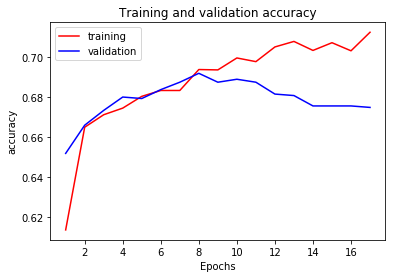

In [19]:
# Generate plots to assess the performance of the NN
ev.plot_learning_curve(history_dict = FNN_history_dict, metric = 'accuracy', set = 'train_valid')

In [40]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_FNN(model = FNN_model, 
                                                   cue_seq = cue1_seq,  
                                                   cue_index = cue_to_index,
                                                   max_len = None,
                                                   vector_encoding = 'onehot')
outcome1_prob_pred

array([0.9309136 , 0.06419639], dtype=float32)

In [37]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_FNN(model = FNN_model, 
                                           data_test = names_test,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index,
                                           max_len = None,
                                           vector_encoding = 'onehot')

In [38]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.672566371681416

In [34]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.6686217  0.67655786]


## IV. Long short-term memory model <a ID="IV"></a> 

### Tokenisation

In [53]:
# Extract an event
event1 = names_train.iloc[[1]]
event1

,cues,outcomes
1,k_y_r_i_e,f


In [58]:
# cues
cues1 = names_train.loc[names_train.index[1], 'cues']
cues1_onehot_LSTM = md.seq_to_onehot_2darray(cues1, index_system = cue_to_index, N_tokens = N_cues, max_len = 10)
cues1_onehot_LSTM

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [57]:
# outcomes
outcomes1 = names_train.loc[names_train.index[1], 'outcomes']
outcomes1_onehot_LSTM = md.seq_to_onehot_1darray(outcomes1, index_system = outcome_to_index, N_tokens = N_outcomes)
outcomes1_onehot_LSTM

array([0., 1.])

### Build a simple LSTM model

Build a simple LSTM that has 64 hidden units 

In [60]:
### Build a simple LSTM that has 64 hidden units 
p = {'max_len': 11,
     'epochs': 10, # number of iterations on the full set 
     'batch_size': 16, 
     'embedding_input': None,
     'embedding_dim': 0, 
     'hidden_neuron': 64, # number of neurons in the input layer 
     'lr': 0.0001, # learning rate       
     'dropout': 0.2, 
     'optimizer': RMSprop, 
     'losses': binary_crossentropy, 
     'last_activation': 'sigmoid'}

# Model fitting
LSTM_out, LSTM_model = md.train(model = 'LSTM', 
                                data_train = names_train, 
                                data_valid = names_valid, 
                                cue_index = cue_to_index, 
                                outcome_index = outcome_to_index, 
                                verbose = 2,
                                metrics = ['accuracy'],
                                params = p)

Epoch 1/10
 - 7s - loss: 0.6866 - accuracy: 0.6472 - val_loss: 0.6756 - val_accuracy: 0.6994
Epoch 2/10
 - 7s - loss: 0.6565 - accuracy: 0.6707 - val_loss: 0.6386 - val_accuracy: 0.6533
Epoch 3/10
 - 6s - loss: 0.6229 - accuracy: 0.6610 - val_loss: 0.6261 - val_accuracy: 0.6555
Epoch 4/10
 - 6s - loss: 0.6049 - accuracy: 0.6785 - val_loss: 0.6092 - val_accuracy: 0.6771
Epoch 5/10
 - 6s - loss: 0.5847 - accuracy: 0.7017 - val_loss: 0.5778 - val_accuracy: 0.7009
Epoch 6/10
 - 6s - loss: 0.5634 - accuracy: 0.7217 - val_loss: 0.5360 - val_accuracy: 0.7247
Epoch 7/10
 - 6s - loss: 0.5468 - accuracy: 0.7270 - val_loss: 0.4942 - val_accuracy: 0.7418
Epoch 8/10
 - 6s - loss: 0.5384 - accuracy: 0.7323 - val_loss: 0.4643 - val_accuracy: 0.7381
Epoch 9/10
 - 6s - loss: 0.5308 - accuracy: 0.7376 - val_loss: 0.4400 - val_accuracy: 0.7426
Epoch 10/10
 - 6s - loss: 0.5293 - accuracy: 0.7394 - val_loss: 0.4240 - val_accuracy: 0.7463


In [61]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                23296     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 23,426
Trainable params: 23,426
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [62]:
### Parameter tuning using grid search 
p = {'max_len': [5, 8, 11],
     'embedding_input': [None],
     'embedding_dim': [0],
     'epochs': [1, 5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [8, 16, 32, 64, 128, 256], # (x6)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, Nadam, RMSprop, SGD], # (x4)
     'losses': [binary_crossentropy], # (x1)
     'last_activation': ['sigmoid'] # (x1)
     }
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_LSTM_names.csv'

In [63]:
### Grid search 
md.grid_search(model = 'LSTM',
               data_train = names_train, 
               data_valid = names_valid, 
               cue_index = cue_to_index, 
               outcome_index = outcome_to_index,
               params = p,
               prop_grid = 2e-4, 
               tuning_output_file = TUNING_PATH)

Iteration 1 out of 10: {'max_len': 11, 'embedding_input': None, 'embedding_dim': None, 'epochs': 10, 'batch_size': 16, 'hidden_neuron': 32, 'lr': 0.0002, 'dropout': 0, 'optimizer': <class 'keras.optimizers.Nadam'>, 'losses': <function binary_crossentropy at 0x7fa162292598>, 'last_activation': 'sigmoid'}

Iteration 2 out of 10: {'max_len': 8, 'embedding_input': None, 'embedding_dim': None, 'epochs': 20, 'batch_size': 64, 'hidden_neuron': 16, 'lr': 0.0002, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7fa162292598>, 'last_activation': 'sigmoid'}

Iteration 3 out of 10: {'max_len': 11, 'embedding_input': None, 'embedding_dim': None, 'epochs': 1, 'batch_size': 64, 'hidden_neuron': 64, 'lr': 0.002, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': <function binary_crossentropy at 0x7fa162292598>, 'last_activation': 'sigmoid'}

Iteration 4 out of 10: {'max_len': 8, 'embedding_input': None, 'embedding_dim': None

### Assessing the grid search

In [66]:
# Import the grid search file to analyse the results 
gs_results = pd.read_csv(TUNING_PATH, index_col = False)

# get the number of parameter combinations that were processed
len(gs_results)

128

In [67]:
# Display the dataframe containing the tuning results
gs_results.head()

,max_len,embedding_input,embedding_dim,epochs,batch_size,hidden_neuron,lr,dropout,optimizer,losses,...,loss,acc,precision,recall,f1score,val_loss,val_acc,val_precision,val_recall,val_f1score
0,11,onehot,0,1,16,32,0.0002,0.0,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7fa162292598>,...,0.679871,0.640487,0.645985,0.630531,0.636079,0.663381,0.654018,0.653350,0.657738,0.655387
1,11,onehot,0,2,16,32,0.0002,0.0,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7fa162292598>,...,0.620945,0.660859,0.660806,0.662795,0.661633,0.629188,0.674107,0.675303,0.674107,0.674407
2,11,onehot,0,3,16,32,0.0002,0.0,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7fa162292598>,...,0.586704,0.702802,0.703173,0.702802,0.702709,0.572277,0.693452,0.692279,0.697917,0.694836
3,11,onehot,0,4,16,32,0.0002,0.0,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7fa162292598>,...,0.556002,0.723820,0.723973,0.723636,0.723558,0.502320,0.722470,0.722047,0.724702,0.722966
4,11,onehot,0,5,16,32,0.0002,0.0,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7fa162292598>,...,0.538350,0.732762,0.733806,0.731010,0.732232,0.454574,0.738095,0.738241,0.738095,0.738062


In [68]:
gs_results.columns

Index(['max_len', 'embedding_input', 'embedding_dim', 'epochs', 'batch_size',
       'hidden_neuron', 'lr', 'dropout', 'optimizer', 'losses',
       'last_activation', 'loss', 'acc', 'precision', 'recall', 'f1score',
       'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1score'],
      dtype='object')

In [70]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {gs_results['val_acc'].max()}")
print(f"- Highest validation f1-score: {gs_results['f1score'].max()}")

- Highest validation accuracy: 0.8236607313156128
- Highest validation f1-score: 0.91931564


In [71]:
# get the index of the combination with the best result
i_best = gs_results['val_acc'].argmax()
i_best

84

Iteration 7 produced the highest validation accuracy, corresponding to the following parameters:

In [72]:
# get the best paramaters
gs_results.iloc[i_best, ]

max_len                                                          11
embedding_input                                              onehot
embedding_dim                                                     0
epochs                                                           24
batch_size                                                        8
hidden_neuron                                                    64
lr                                                            0.001
dropout                                                         0.4
optimizer                           <class 'keras.optimizers.Adam'>
losses             <function binary_crossentropy at 0x7fa162292598>
                                         ...                       
loss                                                       0.261525
acc                                                        0.888735
precision                                                   0.88888
recall                                          

### Retraining with the best parameters

In [74]:
### Hyperparameters to use
p = {'max_len': 11,
     'epochs': 24, # number of iterations on the full set 
     'batch_size': 8, 
     'embedding_input': None,
     'embedding_dim': 0, 
     'hidden_neuron': 64, # number of neurons in the input layer 
     'lr': 0.001, # learning rate       
     'dropout': 0.4, 
     'optimizer': Adam, 
     'losses': binary_crossentropy, 
     'last_activation': 'sigmoid'}

# Model fitting
LSTM_hist, LSTM_model = md.train_LSTM(data_train = names_train, 
                                     data_valid = names_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     metrics = ['accuracy'],
                                     verbose = 2,
                                     params = p)

Epoch 1/24
 - 13s - loss: 0.5994 - accuracy: 0.6729 - val_loss: 0.4294 - val_accuracy: 0.7314
Epoch 2/24
 - 13s - loss: 0.5330 - accuracy: 0.7364 - val_loss: 0.4013 - val_accuracy: 0.7530
Epoch 3/24
 - 12s - loss: 0.5085 - accuracy: 0.7542 - val_loss: 0.3967 - val_accuracy: 0.7582
Epoch 4/24
 - 12s - loss: 0.4915 - accuracy: 0.7601 - val_loss: 0.3555 - val_accuracy: 0.7708
Epoch 5/24
 - 12s - loss: 0.4717 - accuracy: 0.7739 - val_loss: 0.3274 - val_accuracy: 0.7902
Epoch 6/24
 - 12s - loss: 0.4488 - accuracy: 0.7910 - val_loss: 0.3228 - val_accuracy: 0.8021
Epoch 7/24
 - 13s - loss: 0.4322 - accuracy: 0.8025 - val_loss: 0.2861 - val_accuracy: 0.8088
Epoch 8/24
 - 12s - loss: 0.4174 - accuracy: 0.8121 - val_loss: 0.2794 - val_accuracy: 0.8110
Epoch 9/24
 - 12s - loss: 0.4073 - accuracy: 0.8177 - val_loss: 0.2516 - val_accuracy: 0.8118
Epoch 10/24
 - 13s - loss: 0.3949 - accuracy: 0.8213 - val_loss: 0.2390 - val_accuracy: 0.8088
Epoch 11/24
 - 13s - loss: 0.3861 - accuracy: 0.8248 - val_

In [75]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/LSTM_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/LSTM_history_dict_names'
md.export_model(model = LSTM_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = LSTM_hist, path = HISTORY_PATH)
del LSTM_model, LSTM_hist  # deletes the existing model and history dictionary

In [76]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/LSTM_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/LSTM_history_dict_names'
LSTM_model = md.import_model(MODEL_PATH)
LSTM_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

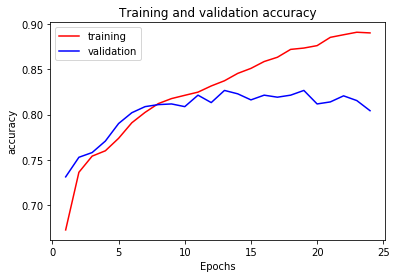

In [78]:
# Generate plots to assess the performance of the simple LSTM
ev.plot_learning_curve(history_dict = LSTM_history_dict, metric = 'accuracy', set = 'train_valid')

In [79]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_LSTM(model = LSTM_model, 
                                                   cue_seq = cue1_seq,  
                                                   cue_index = cue_to_index,
                                                   max_len = 11,
                                                   vector_encoding = 'onehot')
outcome1_prob_pred

array([0.8150622 , 0.20015824], dtype=float32)

In [80]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_LSTM(model = LSTM_model, 
                                           data_test = names_test, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           max_len = 11,
                                           vector_encoding = 'onehot')

In [81]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8053097345132744

In [82]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.85630499 0.7537092 ]


## V. Naive discriminative learning model <a ID="V"></a> 

### Build a simple NDL model

In [100]:
### Build a simple NDL
p = {'epochs': 10, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_history_dict, NDL_model = md.train(model = 'NDL',
                                       data_train = names_train, 
                                       data_valid = names_valid,  
                                       cue_index = cue_to_index, 
                                       outcome_index = outcome_to_index, 
                                       params = p,
                                       num_threads = 16,
                                       verbose = 1)

Epoch 1/10
 - 21s - acc: 0.6461 - val_acc: 0.6519
Epoch 2/10
 - 21s - acc: 0.6535 - val_acc: 0.6637
Epoch 3/10
 - 21s - acc: 0.6590 - val_acc: 0.6622
Epoch 4/10
 - 21s - acc: 0.6629 - val_acc: 0.6637
Epoch 5/10
 - 20s - acc: 0.6638 - val_acc: 0.6681
Epoch 6/10
 - 21s - acc: 0.6629 - val_acc: 0.6740
Epoch 7/10
 - 21s - acc: 0.6635 - val_acc: 0.6770
Epoch 8/10
 - 21s - acc: 0.6648 - val_acc: 0.6711
Epoch 9/10
 - 21s - acc: 0.6659 - val_acc: 0.6681
Epoch 10/10
 - 21s - acc: 0.6668 - val_acc: 0.6637


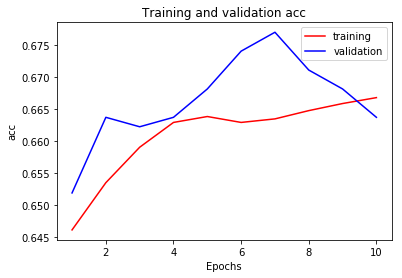

In [101]:
# Generate learning curve
ev.plot_learning_curve(history_dict = NDL_history_dict, metric = 'acc', set = 'train_valid')

### Tune the parameters to find a good model

In [122]:
### Parameter tuning using grid search 
p = {'lr': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], # learning rate (x8)
     'epochs': [8, 6, 4, 2, 1], # number of iterations on the full set (x5)
     }
# => Total number of combinations: 8*5 = 40

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_NDL_names.csv'
md.grid_search(model = 'NDL', 
               data_train = names_train, 
               data_valid = names_valid, 
               cue_index = cue_to_index, 
               outcome_index = outcome_to_index, 
               params = p, 
               prop_grid = 0.2, 
               shuffle_grid = True,
               tuning_output_file = TUNING_PATH, 
               num_threads = 16)

Iteration 1 out of 8: {'lr': 0.001, 'epochs': 2}

Iteration 2 out of 8: {'lr': 0.01, 'epochs': 4}

Iteration 3 out of 8: {'lr': 0.005, 'epochs': 8}

Iteration 4 out of 8: {'lr': 5e-05, 'epochs': 2}

Iteration 5 out of 8: {'lr': 0.01, 'epochs': 8}

Iteration 6 out of 8: {'lr': 0.0005, 'epochs': 2}

Iteration 7 out of 8: {'lr': 1e-05, 'epochs': 1}

Iteration 8 out of 8: {'lr': 1e-05, 'epochs': 4}



### Assessing the grid search

In [123]:
# Import the grid search file to analyse the results 
gs_results = pd.read_csv(TUNING_PATH, index_col = False)

# get the number of parameter combinations that were processed
len(gs_results)

31

In [124]:
# Display the dataframe containing the tuning results
gs_results.head()

,lr,epochs,acc,precision,recall,f1score,val_acc,val_precision,val_recall,val_f1score
0,0.001,1,0.646148,0.646079,0.645761,0.645750,0.651917,0.651917,0.651923,0.651914
1,0.001,2,0.653520,0.653400,0.653288,0.653309,0.663717,0.663774,0.663757,0.663714
2,0.010,1,0.664762,0.667603,0.665738,0.664089,0.671091,0.673730,0.671437,0.670109
3,0.010,2,0.666605,0.669742,0.667633,0.665844,0.668142,0.671271,0.668522,0.666924
4,0.010,3,0.663656,0.666859,0.664702,0.662852,0.669617,0.672912,0.670005,0.668344


In [125]:
gs_results.columns

Index(['lr', 'epochs', 'acc', 'precision', 'recall', 'f1score', 'val_acc',
       'val_precision', 'val_recall', 'val_f1score'],
      dtype='object')

In [127]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {gs_results['val_acc'].max()}")
print(f"- Highest validation f1-score: {gs_results['f1score'].max()}")

- Highest validation accuracy: 0.6784660766961652
- Highest validation f1-score: 0.6663799498293685


In [128]:
# get the index of the combination with the best result
i_best = gs_results['val_acc'].argmax()
i_best

6

Iteration 7 produced the highest validation accuracy, corresponding to the following parameters:

In [129]:
# get the best paramaters
gs_results.iloc[i_best, ]

lr               0.005000
epochs           1.000000
acc              0.661261
precision        0.661246
recall           0.660859
f1score          0.660853
val_acc          0.678466
val_precision    0.678649
val_recall       0.678350
val_f1score      0.678287
Name: 6, dtype: float64

### Retraining with the best parameters

In [130]:
### Hyperparameters to use
p = {'epochs': 1, # number of iterations on the full set 
    'lr': 0.005}

# Model fitting
NDL_history_dict, NDL_model = md.train_NDL(data_train = names_train, 
                                           data_valid = names_valid,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           params = p,
                                           num_threads = 16, 
                                           verbose = 1)

Epoch 1/1
 - 21s - acc: 0.6613 - val_acc: 0.6785


In [131]:
# Save the weights and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/NDL_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/NDL_history_dict_names'
md.export_model(model = NDL_model, path = MODEL_PATH)  # create a HDF5 file 
md.export_history(history_dict = NDL_history_dict, path = HISTORY_PATH)
del NDL_model, NDL_history_dict  # delete the existing model and history dictionary

In [132]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/NDL_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/NDL_history_dict_names'
NDL_model = md.import_model(MODEL_PATH)
NDL_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [142]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_NDL(model = NDL_model, 
                                                   cue_seq = cue1_seq)
outcome1_prob_pred

array([0.67011605, 0.32988395])

In [148]:
### Evaluate the model on the test set

# True outcomes to compare the predictions to
y_test = names_test['outcomes'].tolist()

# Predicted outcomes
y_pred = ev.predict_outcomes_NDL(model = NDL_model, 
                                 data_test = names_test, 
                                 num_threads = 16)

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6784660766961652

In [158]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred, labels = list(outcome_to_index.keys())) # Confusion matrix
cmat_diag = cmat.diagonal()/cmat.sum(axis=1)
print({index_to_outcome[j+1]:cmat_diag[j] for j in range(len(cmat_diag))})

{'m': 0.6979472140762464, 'f': 0.658753709198813}
